## Understanding how the environment works

In [124]:
import os, sys
import gymnasium as gym
import time

import text_flappy_bird_gym

if __name__ == '__main__':

    # initiate environment
    env = gym.make('TextFlappyBird-v0', height = 15, width = 20, pipe_gap = 4)
    obs = env.reset()

    # iterate
    while True:

        # Select next action
        action = env.action_space.sample()  # for an agent, action = agent.policy(observation)

        # Appy action and return new observation of the environment
        obs, reward, done, _, info = env.step(action)

        # Render the game
        os.system("clear")
        sys.stdout.write(env.render())
        time.sleep(0.2) # FPS

        # If player is dead break
        if done:
            break

    env.close()

Text Flappy Bird!
Score: 0
----------------------
[                  | ]
[                  | ]
[                  | ]
[                  | ]
[                    ]
[                    ]
[                    ]
[      @             ]
[                  | ]
[                  | ]
[                  | ]
[                  | ]
[                  | ]
[                  | ]
[                  | ]
^^^^^^^^^^^^^^^^^^^^^^
Player Action (Idle)
Distance From Pipe (dx=12,dy=1)
Text Flappy Bird!
Score: 0
----------------------
[                 |  ]
[                 |  ]
[                 |  ]
[                 |  ]
[                    ]
[                    ]
[      @             ]
[                    ]
[                 |  ]
[                 |  ]
[                 |  ]
[                 |  ]
[                 |  ]
[                 |  ]
[                 |  ]
^^^^^^^^^^^^^^^^^^^^^^
Player Action (Flap)
Distance From Pipe (dx=11,dy=0)
Text Flappy Bird!
Score: 0
----------------------
[       

In [125]:
import scipy
import numpy as np

# Ausiliary function
def discount_cumsum(x, discount):
    """
    magic for computing discounted cumulative sums of vectors.
    input:
        vector x,
        [x0,
         x1,
         x2]
    output:
        [x0 + discount * x1 + discount^2 * x2,
         x1 + discount * x2,
         x2]
    """
    return scipy.signal.lfilter([1], [1, float(-discount)], x[::-1], axis=0)[::-1]

In [126]:
env = gym.make('TextFlappyBird-v0', height = 15, width = 20, pipe_gap = 4)

In [127]:
obs = env.reset()
print(obs)
os.system("clear")
sys.stdout.write(env.render())
time.sleep(0.2) # 

((13, -2), {'score': 0, 'player': [6, 7], 'distance': 13.152946437965905})
Text Flappy Bird!
Score: 0
----------------------
[                   |]
[                   |]
[                   |]
[                   |]
[                   |]
[                   |]
[                   |]
[      @             ]
[                    ]
[                    ]
[                    ]
[                   |]
[                   |]
[                   |]
[                   |]
^^^^^^^^^^^^^^^^^^^^^^
Player Action (Idle)
Distance From Pipe (dx=13,dy=-2)


In [128]:
action = env.action_space.sample()  # for an agent, action = agent.policy(observation)
print("action", action)
# Appy action and return new observation of the environment
obs, reward, done, _, info = env.step(action)

print("obs", obs, "\nreward",reward, "\ndone",done, "\ninfo",info)

action 0
obs (12, -2) 
reward 1 
done False 
info {'score': 0, 'player': [6, 7], 'distance': 12.165525060596439}


## Trying to see if Q-Evaluation code works

In [130]:
class Q_Evaluation():
    def __init__(self, 
                 space_size,    # i.e. minimum and maximum observations that the agent can receive
                 action_size,   # i.e. how many actions are possible
                 policy,        # i.e. the policy to be evaluated, as an array 
                 gamma=1,       # i.e. the discount factor
                 lr_v=0.01):    # i.e. the learning rate
        """
        Evaluates Q-value for (S,A) pairs, using one-step updates.        
        """
        
        # the discount factor
        self.gamma = gamma
        # size of system
        self.space_size = space_size # as tuple
        self.action_size = action_size 

        # policy to evaluate
        self.policy = policy
        
        # the learning rate
        self.lr_v = lr_v
        
        # where to save returns
        self.Qvalues = np.zeros((*self.space_size, self.action_size))
    
        # ------ ALERT! -------
        # SMALL TECHNICAL NOTE: puttin an asterix before a list/array/tuple A, i.e. *A
        # unpacks its values.
        # For example if self.size = (3,2) and self.action_size is 4 
        # then  (*self.size, self.action_size) = (3,2,4)
        # Also if s is an array [3,2] 
        # (*s,) = (3,2)
        
    
    # -------------------   
    def single_step_update(self, s, a, r, new_s, done):
        """
        Uses a single step to update the values.
        """
        
        # Indexing should be a tuple
        # index state/action = (*s, a)
        # index new_state/action = (*new_s, a)
        
        if done:
            # in TD(0) it was
            # delta = (r + 0 - self.values[s])

            deltaQ = (r + 0 - self.Qvalues[ (*s, a) ])
        else:
            # in TD(0) it was
            # delta = (r + gamma*self.values[new_s] - self.values[s])

            deltaQ = ( r + 
                            # np.dot(A,B) = sum_i A_i*B_i
                      self.gamma * np.dot( self.Qvalues[ (*new_s,) ], self.policy[ (*new_s,) ] ) 
                                                                - self.Qvalues[ (*s,a) ] )
            # Notice that I calculate the expected Qvalue in new_s over all possibilities!            

        self.Qvalues[ (*s, a)] += self.lr_v * deltaQ
        
    # ---------------------
    def get_action_from_policy(self, s):
        """
        Select one action with probabilities defined by the policy to evaluate.
        """
        a = np.random.choice(self.action_size, p=self.policy[ (*s,) ])
        return a

In [131]:
env = gym.make('TextFlappyBird-v0', height = 15, width = 20, pipe_gap = 4)
obs = env.reset()

In [132]:
list(range(env.observation_space[0].n))
list(range(env.observation_space[1].n)) + env.observation_space[1].start

array([-11, -10,  -9,  -8,  -7,  -6,  -5,  -4,  -3,  -2,  -1,   0,   1,
         2,   3,   4,   5,   6,   7,   8,   9,  10])

In [133]:
observation_space = (env.observation_space[0].n, env.observation_space[1].n) # we ignore start, simply careful when reading Q_Values

random_policy = np.zeros( (observation_space[0],observation_space[1],2) ) # 2 is the number of actions
random_policy[:,:] = [0.5, 0.5]

In [134]:
observation_space = (env.observation_space[0].n, env.observation_space[1].n)
QEval = Q_Evaluation(space_size=observation_space, 
                     action_size=2, policy=random_policy, gamma=1, lr_v=0.1)

In [135]:
n_episodes = 1000

# Initialize 
QEval = Q_Evaluation(space_size=observation_space, 
                     action_size=2, policy=random_policy, gamma=1, lr_v=0.1)

Actions = [0, 1]

# RUN OVER EPISODES
for i in range(n_episodes):
    done = False

    s, info = env.reset()
    a = QEval.get_action_from_policy(s)
    act = Actions[a]
    while not done:
        new_s, r, done, _, info = env.step(act)
        QEval.single_step_update(s, a, r, new_s, done)
        a = QEval.get_action_from_policy(new_s)
        act = Actions[a]
        s = new_s


Qvalues = QEval.Qvalues


In [16]:
Qvalues # qualcosa fa, ora c'è da vedere se la fa giusta

array([[[2.31291997, 2.33909391],
        [2.25516593, 2.18960274],
        [0.        , 0.        ],
        [0.        , 0.        ],
        [0.        , 0.        ],
        [0.        , 0.        ],
        [0.        , 0.        ],
        [0.        , 0.        ],
        [0.        , 0.        ],
        [0.        , 0.        ],
        [0.        , 0.        ],
        [0.        , 0.        ],
        [0.        , 0.        ],
        [0.        , 0.        ],
        [0.        , 0.        ],
        [0.        , 0.        ],
        [0.        , 0.        ],
        [0.        , 0.        ],
        [0.        , 0.        ],
        [0.        , 0.        ],
        [2.56838965, 2.38483457],
        [2.05561335, 2.681943  ]],

       [[1.48785493, 2.11373549],
        [0.87842335, 2.30397671],
        [0.87842335, 2.02688741],
        [0.87842335, 0.83322818],
        [0.61257951, 0.81469798],
        [0.74581342, 0.71757046],
        [0.6861894 , 0.77123208],
        [0.4

# Trying to implement SARSA to see if it works

In [136]:
class SARSA_TDControl():
    def __init__(self, 
                 space_size, 
                 action_size, 
                 gamma=1, 
                 lr_v=0.01):
        """
        Calculates optimal policy using in-policy Temporal Difference control
        Evaluates Q-value for (S,A) pairs, using one-step updates.
        """        
        # the discount factor
        self.gamma = gamma
        # size of system
        self.space_size = space_size # as tuple
        self.action_size = action_size

        # the learning rate
        self.lr_v = lr_v
        
        # where to save returns
        self.Qvalues = np.zeros( (*self.space_size, self.action_size) )
    
    # -------------------   
    def single_step_update(self, s, a, r, new_s, new_a, done):
        """
        Uses a single step to update the values, using Temporal Difference for Q values.
        Employs the EXPERIENCED action in the new state  <- Q(S_new, A_new).
        """
        if done:
            
            
            # CODE HERE!
            # deltaQ = R - Q(s,a)
            
            deltaQ = (r + 0 - self.Qvalues[ (*s, a) ])
        else:
            
            # CODE HERE!
            # deltaQ = R + gamma*Q(new_s, new_a) - Q(s,a)
            
            deltaQ = (r + 
                      self.gamma * self.Qvalues[ (*new_s, new_a) ] 
                                 - self.Qvalues[ (*    s,     a) ])
            
        self.Qvalues[ (*s, a) ] += self.lr_v * deltaQ
        
    # ---------------------
    def get_action_epsilon_greedy(self, s, eps):
        """
        Chooses action at random using an epsilon-greedy policy wrt the current Q(s,a).
        """
        ran = np.random.rand()
        
        # CODE HERE!
        
        if (ran < eps):
            # probability is uniform for all actions!
            prob_actions = np.ones(self.action_size) / self.action_size 
        
        else:
            # I find the best Qvalue
            best_value = np.max(self.Qvalues[ (*s,) ])
            
            # There could be actions with equal value! 
            best_actions = ( self.Qvalues[ (*s,) ] == best_value )


            # best_actions is 
            # *True* if the value is equal to the best (possibly ties)
            # *False* if the action is suboptimal
            prob_actions = best_actions / np.sum(best_actions)
            
        # take one action from the array of actions with the probabilities as defined above.
        a = np.random.choice(self.action_size, p=prob_actions)
        return a 
        
    def greedy_policy(self):
        
        # CODE HERE!
        
        a = np.argmax(self.Qvalues, axis = 2)
        return a

In [159]:
n_episodes = 20000
Actions = [0, 1] # flap / no flap
observation_space = (env.observation_space[0].n, env.observation_space[1].n)

# Initialize 
SARSA = SARSA_TDControl(space_size=observation_space, action_size=2, gamma=0.7, lr_v=0.15)
epsilon = 0.15

performance_traj_SARSA = np.zeros(n_episodes)

# RUN OVER EPISODES
for i in range(n_episodes):
    done = False

    s, info = env.reset()
    a = SARSA.get_action_epsilon_greedy(s, epsilon)
    act = Actions[a]
    
    while not done:
    #for _ in range(100):
        # Evolve one step
        new_s, r, done, _, info = env.step(act)
        
        # Keeps track of performance for each episode
        performance_traj_SARSA[i] += r
        
        # Choose new action index
        new_a = SARSA.get_action_epsilon_greedy(new_s, epsilon)
        #print(s,act,a, r,new_s,new_a, done, ' Qvalue ', SARSA.Qvalues[(*s,)])
        # (Corresponding action to index)
        act = Actions[new_a]
        # Single update with (S, A, R', S', A')
        SARSA.single_step_update(s, a, r, new_s, new_a, done)
        
        a = new_a
        s = new_s

Qvalues = SARSA.Qvalues

In [160]:
plot_indexes = np.arange(0, n_episodes+1, 20, dtype=int) # Only plot a sub-plot of results
plot_indexes[-1] = plot_indexes[-1]-1

Text(0.5, 1.0, 'SARSA cumulative rewards')

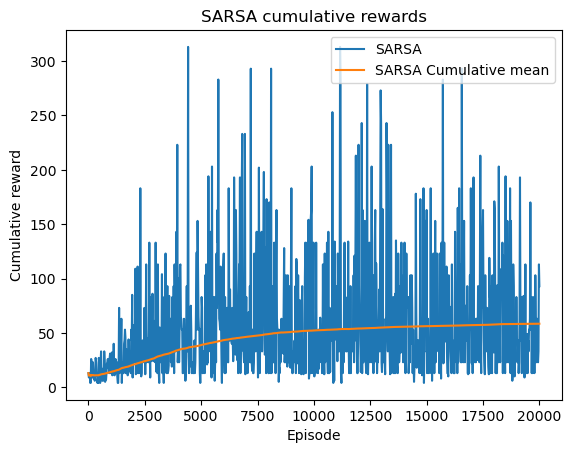

In [161]:
import matplotlib.pyplot as plt
cumulative_mean_SARSA = np.cumsum(performance_traj_SARSA) / np.arange(1, len(performance_traj_SARSA) + 1)

plt.plot(plot_indexes, performance_traj_SARSA[plot_indexes], label='SARSA')
plt.plot(plot_indexes, cumulative_mean_SARSA[plot_indexes], label = 'SARSA Cumulative mean')
plt.xlabel('Episode')
plt.ylabel('Cumulative reward')
plt.legend()
plt.title("SARSA cumulative rewards")

Text(0.5, 1.0, 'SARSA cumulative rewards')

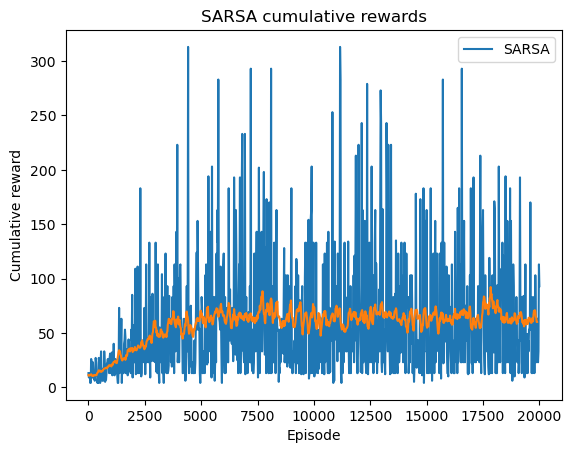

In [188]:
window_size = 100
local_mean_SARSA = np.convolve(performance_traj_SARSA, np.ones(window_size) / window_size, mode='valid')
local_mean_SARSA.shape


plt.plot(plot_indexes, performance_traj_SARSA[plot_indexes], label='SARSA')
plt.plot(plot_indexes[plot_indexes < local_mean_SARSA.shape[0]], local_mean_SARSA[plot_indexes[plot_indexes < local_mean_SARSA.shape[0]]])
plt.xlabel('Episode')
plt.ylabel('Cumulative reward')
plt.legend()
plt.title("SARSA cumulative rewards")

# Trying to implement Q-Learning to see if they work

In [189]:
class Qlearning_TDControl():
    def __init__(self, 
                 space_size, 
                 action_size, 
                 gamma=1, 
                 lr_v=0.01):
        """
        Calculates optimal policy using off-policy Temporal Difference control
        Evaluates Q-value for (S,A) pairs, using one-step updates.
        """            
        # the discount factor
        self.gamma = gamma
        # size of system
        self.space_size = space_size # as tuple
        self.action_size = action_size

        # the learning rate
        self.lr_v = lr_v
        
        # where to save returns
        self.Qvalues = np.zeros( (*self.space_size, self.action_size) )
    
    # -------------------   
    def single_step_update(self, s, a, r, new_s, done):
        """
        Uses a single step to update the values, using Temporal Difference for Q values.
        Uses the BEST (evaluated) action in the new state <- Q(S_new, A*) = max_A Q(S_new, A).
        """
        if done:
            
            # CODE HERE !
            # deltaQ = R - Q(s,a) 
            
            deltaQ = (r + 0 - self.Qvalues[ (*s, a) ])
        else:

            
            # CODE HERE!
            # deltaQ = R + gamma*max_act Q(new_s, act)- Q(s,a) 
            
            maxQ_over_actions = np.max(self.Qvalues[ (*new_s,) ])
            
            deltaQ = (r + 
                      self.gamma * maxQ_over_actions 
                                 - self.Qvalues[ (*s,a) ])
        
        self.Qvalues[ (*s, a) ] += self.lr_v * deltaQ
            
    # ---------------------
    def get_action_epsilon_greedy(self, s, eps):
        """
        Chooses action at random using an epsilon-greedy policy wrt the current Q(s,a).
        """
        
        
        ran = np.random.rand()
        
        if (ran < eps):
            # probability is uniform for all actions!
            prob_actions = np.ones(self.action_size) / self.action_size 
        
        else:
            # I find the best Qvalue
            best_value = np.max(self.Qvalues[ (*s,) ])
            
            # There could be actions with equal value! 
            best_actions = ( self.Qvalues[ (*s,) ] == best_value )


            # best_actions is 
            # *True* if the value is equal to the best (possibly ties)
            # *False* if the action is suboptimal
            prob_actions = best_actions / np.sum(best_actions)
            
        # take one action from the array of actions with the probabilities as defined above.
        a = np.random.choice(self.action_size, p=prob_actions)
        return a 
        
    def greedy_policy(self):
        
        a = np.argmax(self.Qvalues, axis = 2)
        return a

In [192]:
# Q-Learning Control
n_episodes = 20000
Actions = [0, 1] # flap / no flap
observation_space = (env.observation_space[0].n, env.observation_space[1].n)


# Initialize 
QLearning = Qlearning_TDControl(space_size=observation_space, action_size=2, gamma=0.7, lr_v=0.15)
epsilon = 0.15


performance_traj_Q = np.zeros(n_episodes)

# RUN OVER EPISODES
for i in range(n_episodes):
    done = False

    s, info = env.reset()
    a = QLearning.get_action_epsilon_greedy(s, epsilon)
    act = Actions[a]
    
    while not done:
    #for _ in range(100):
        # Evolve one step
        new_s, r, done, _, info = env.step(act)
        
        # Keeps track of performance for each episode
        performance_traj_Q[i] += r
        
        # Choose new action index
        new_a = QLearning.get_action_epsilon_greedy(new_s, epsilon)
        #print(s,act,a, r,new_s,new_a, done, ' Qvalue ', SARSA.Qvalues[(*s,)])
        # (Corresponding action to index)
        act = Actions[new_a]
        # Single update with (S, A, R', S')
        QLearning.single_step_update(s, a, r, new_s, done)
        
        a = new_a
        s = new_s


Qvalues_QLearning = QLearning.Qvalues

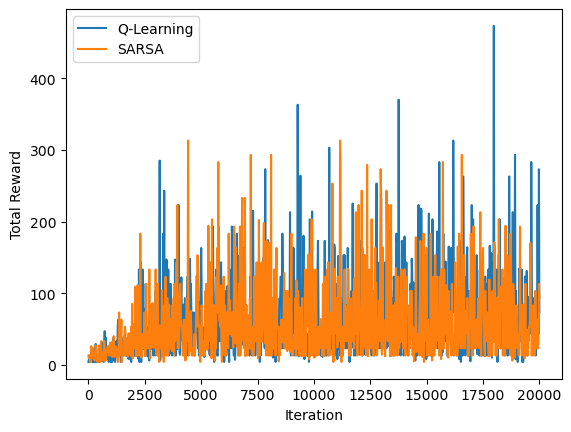

In [193]:
import matplotlib.pyplot as plt
plt.plot(plot_indexes, performance_traj_Q[plot_indexes], label='Q-Learning')
plt.plot(plot_indexes, performance_traj_SARSA[plot_indexes], label='SARSA')
plt.legend()
plt.xlabel("Iteration")
plt.ylabel("Total Reward")
plt.show()

# Expected SARSA

Va ancora aggiustato


In [194]:
class EXPECTED_SARSA_TDControl():
    def __init__(self, space_size, action_size, gamma=1, lr_v=0.01):
        """
        Calculates optimal policy using in-policy Temporal Difference control
        Evaluates Q-value for (S,A) pairs, using one-step updates.
        """        
        # the discount factor
        self.gamma = gamma
        # size of system
        self.space_size = space_size 
        self.action_size = action_size

        # the learning rate
        self.lr_v = lr_v
        
        # where to save returns
        self.Qvalues = np.zeros( (*self.space_size, self.action_size) )
    
    # -------------------   
    def single_step_update(self, s, a, r, new_s, done, eps):
        """
        Uses a single step to update the values, using Temporal Difference for Q values.
        Employs the EXPERIENCED action in the new state  <- Q(S_new, A_new).
        """
        if done:
            
            # CODE HERE!
            #deltaQ =  R - Q(s,a)
            
            deltaQ = (r + 0 - self.Qvalues[ (*s, a) ])
        else:
            
            # CODE HERE!
            #deltaQ =  R + sum_b pi(b, new_s) Q(new_s, b) - Q(s,a)
            
            deltaQ = (r + 
                      self.gamma * np.dot( self.Qvalues[ (*new_s,)], self.policy(new_s, eps)) 
                                                                      - self.Qvalues[(*s,a)])
        self.Qvalues[(*s,a) ] += self.lr_v * deltaQ
        
       
    # ---------------------
    def get_action_epsilon_greedy(self, s, eps):
        """
        Chooses action at random using an epsilon-greedy policy wrt the current Q(s,a).
        """
        
                
        # CODE HERE!
        # ... ACTUALLY, COPY AND PASTE FROM SARSA!
        
        ran = np.random.rand()
        
        if (ran < eps):
            # probability is uniform for all actions!
            prob_actions = np.ones(self.action_size) / self.action_size 
        
        else:
            # I find the best Qvalue
            best_value = np.max(self.Qvalues[ (*s,) ])
            
            # There could be actions with equal value! 
            best_actions = ( self.Qvalues[ (*s,) ] == best_value )


            # best_actions is 
            # *True* if the value is equal to the best (possibly ties)
            # *False* if the action is suboptimal
            prob_actions = best_actions / np.sum(best_actions)
            
        # take one action from the array of actions with the probabilities as defined above.
        a = np.random.choice(self.action_size, p=prob_actions)
        return a 
        
    def greedy_policy(self):
        """
        Calculates the greedy policy given current Qvalues.
        """
        greedy_pol = np.argmax(self.Qvalues, axis = 2)
        return greedy_pol

In [ ]:
# Expected SARSA Control

n_episodes = 2000

# Initialize 
ExpSARSA = EXPECTED_SARSA_TDControl(space_size=World.shape, action_size=4, gamma=gamma, lr_v=0.15)
epsilon = 0.15


performance_traj_ExpSARSA = np.zeros(n_episodes)

# RUN OVER EPISODES
for i in range(n_episodes):
    done = False

    env.reset()
    s = env.current_state
    a = ExpSARSA.get_action_epsilon_greedy(s, epsilon)
    act = Actions[a]
    
    while not done:
    #for _ in range(100):
        # Evolve one step
        new_s, r, done = env.step(act)
        
        # Keeps track of performance for each episode
        performance_traj_ExpSARSA[i] += r
        
        # Choose new action index
        new_a = ExpSARSA.get_action_epsilon_greedy(new_s, epsilon)
        # (Corresponding action to index)
        act = Actions[new_a]
        # Single update with (S, A, R', S')
        ExpSARSA.single_step_update(s, a, r, new_s, done, epsilon)
        
        a = new_a
        s = new_s


Qvalues_ExpSARSA = ExpSARSA.Qvalues

Ovviamente non sono top questi, in quanto dobbiamo aggiustare i parametri.
- epsilon di epsilon-greedy dovrebbe andare a 0, cosi che via via che abbiamo esplorato exploitiamo di piu.
- la learning rate dovrebbe andare a 0 (per la convergenza della stochastic approximation)